In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
data_folder = "D:/korean-single-speaker-speech-dataset/kss"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [3]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [4]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [5]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [6]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output

In [7]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

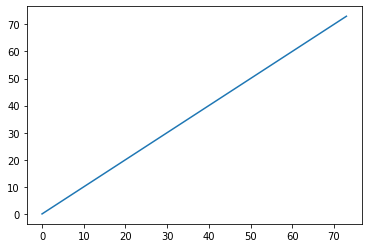

In [8]:
plt.plot(jamo_tokens)
plt.show()

In [9]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [10]:
# embedding_layer = nn.Embedding(len(jamo_tokens), 256)

# print(metadata[5031, 3])
# print(metadata[5031, 2])
# print(len(metadata[5031, 3]))

# input_token = tokenizer.word2num(metadata[5031, 3])
# input_tensor = torch.tensor(input_token)
# plt.imshow(embedding_layer(input_tensor).detach().numpy())

In [11]:
class Encoder(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.H = H
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        
        self.fc_2 = torch.nn.Linear(H, H)
        self.relu_2 = torch.nn.ReLU()
        
        self.gru = nn.GRU(H, D_out, num_layers=3, bidirectional=True, batch_first=True)
        self.relu_gru = torch.nn.ReLU()

    def forward(self, input_tensor):
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        output_tensor = self.relu_gru(output_tensor)
        
        output_tensor = self.fc_2(output_tensor)
        output_tensor = self.relu_2(output_tensor)
        return output_tensor
    
class Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(Decoder, self).__init__()
        self.H = H
        self.fc_embed = nn.Linear(256, 1024)
        self.gru = nn.GRU(2 * H, H, batch_first=True)
        self.attention = AttentionModule(D_out * 2)
        self.fc = nn.Linear(1024, 74)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, input_tensor, hidden_tensor, query):
#         print("Input tensor shape in Decoder: {}".format(input_tensor.shape))
#         print("Hidden_tensor shape in Decoder: {}".format(hidden_tensor.shape))
        output_tensor = self.fc_embed(input_tensor)
#         print("Output tensor shape in Decoder: {}".format(output_tensor.shape))
        output_tensor, hidden_tensor = self.gru(output_tensor, hidden_tensor)
        
#         print("Hidden_tensor shape in Decoder: {}".format(hidden_tensor.shape))
#         print("Output tensor shape in Decoder: {}".format(output_tensor.shape))
        
        context_vector, alpha = self.attention(query, output_tensor)
        output_tensor = torch.cat([output_tensor, context_vector], dim=2)
#         print('output_tensor: {}'.format(output_tensor.shape))
#         print('output_tensor: {}'.format(context_vector.shape))
        output_tensor = self.fc(output_tensor)
        prediction_tensor = self.softmax(output_tensor)

        return prediction_tensor, hidden_tensor, context_vector, alpha

class AttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(AttentionModule, self).__init__()
        self.fc_alpha = nn.Linear(H, 1)
        self.W = nn.Linear(H, H)
        self.V = nn.Linear(H, H)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
        output_tensor = torch.tanh(torch.add(self.W(query), self.V(key)))
        e = self.fc_alpha(output_tensor)
        e_sig = self.sigmoid(e)
        alpha = self.softmax(e_sig).transpose(1, 2)
        context_vector = torch.bmm(alpha, query)
        
        return context_vector, alpha

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        self.encoder = Encoder(D_in, H, D_out).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = Decoder(H, D_out).to(device)
        self.encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=0.01)
        self.decoder_optimizer = optim.SGD(self.decoder.parameters(), lr=0.01)
        self.embedding_optimizer = optim.SGD(self.embedding_layer.parameters(), lr=0.01)
        
        self.criterion = nn.CrossEntropyLoss(reduction='none')

    def train(self, input_tensor, ground_truth, loss_mask):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)
        decoder_hidden = encoded_tensor[:, -1, :].view(1, batch_size, self.H).contiguous()
#         decoder_hidden = encoded_tensor[:, -1, :].transpose(0, 1)
        
        pred_tensor_list = list()
        att_weight_list = list()
        
        loss = 0
        
        decoder_input = self.embedding_layer(torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).to(device)).view([batch_size, 1, -1])
        
#         print(encoded_tensor.shape)
#         print(decoder_hidden.shape)
#         print(decoder_input.shape)
        
        for i in range(ground_truth.shape[1]):
            
            pred_tensor, decoder_hidden, context_vector, att_weight = self.decoder(decoder_input, decoder_hidden, encoded_tensor)
            pred_tensor_list.append(pred_tensor)
            att_weight_list.append(att_weight)
            
#             print('pred_tensor shape: {}'.format(pred_tensor.shape))
            truth = ground_truth[:, i]
            truth = truth.type(torch.cuda.LongTensor)
            
            loss += torch.dot(loss_mask[:, i], self.criterion(pred_tensor.view([batch_size, -1]), truth)) / batch_size
            decoder_input = self.embedding_layer(truth).view([batch_size, 1, -1])
            
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()

        pred_tensor = torch.cat(pred_tensor_list, dim=1)
        attention_matrix = torch.cat(att_weight_list, dim=1)
        
        return pred_tensor, attention_matrix, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
    
net = Mel2SeqNet(80, 512, 256)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [21]:
# class Preloader():
#     def __init__(self, mel_path_list):
#         super(Preloader).__init__()
#         self.mel_path_list = mel_path_list
#         self.tensor_input_list = [None] * len(mel_path_list)
    
#     def load(self, i):
#         norm_log_mel_specgram = np.load(self.mel_path_list[i])
#         input_spectrogram = norm_log_mel_specgram.T
#         tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
#         self.tensor_input_list[i] = tensor_input
        
#     def get(self, i):
#         if type(self.tensor_input_list[i]) == type(None):
#             self.load(i)
#         return self.tensor_input_list[i]  
    
#     def get_batch(self):
        
#         return batched_tensor, indxes 

In [16]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 4
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        
        for order in range(count):
            batched_tensor[order, :tensor_size_list[order], :] = tensor_list[order]
#             print(ground_truth_size_list[order])
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask
        
#         return batched_tensor, ground_truth_tensor 

In [17]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [20]:
# preloader = Preloader(mel_path_list)
preloader = Batched_Preloader(mel_path_list, ground_truth_list, 32)

08-24 21:52:28
Calculated 100 Batches
Loss 100: 3.793433427810669
08-24 21:52:46


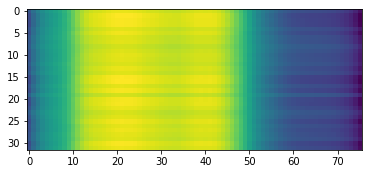

Calculated 200 Batches
Loss 200: 3.8138957977294923
08-24 21:53:12


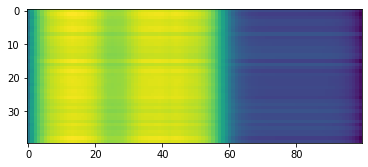

Calculated 300 Batches
Loss 300: 3.8486833572387695
08-24 21:53:43


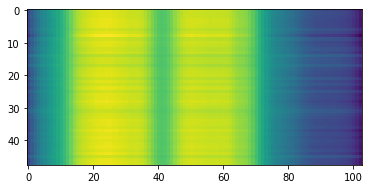

Calculated 400 Batches
Loss 400: 3.7939543290571733
08-24 21:54:22


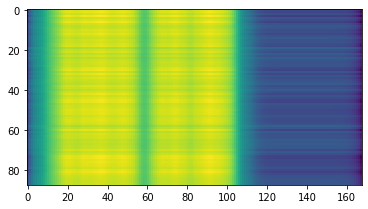

Mean Loss: 3.825338552141067
----------------------------------------------------
08-24 21:54:23
Calculated 100 Batches
Loss 100: 3.7435948848724365
08-24 21:54:41


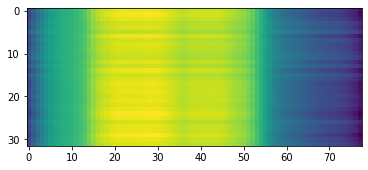

Calculated 200 Batches
Loss 200: 3.857466125488281
08-24 21:55:07


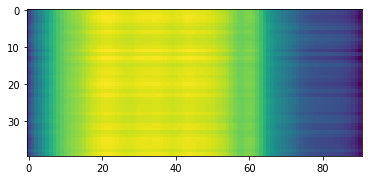

Calculated 300 Batches
Loss 300: 3.8473873138427734
08-24 21:55:38


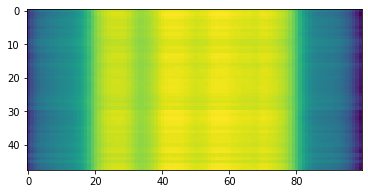

Calculated 400 Batches
Loss 400: 3.780720450661399
08-24 21:56:19


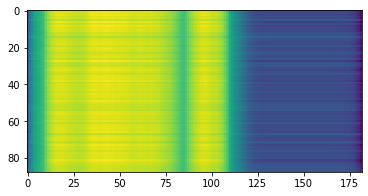

Mean Loss: 3.8253762620334393
----------------------------------------------------
08-24 21:56:20
Calculated 100 Batches
Loss 100: 3.771472930908203
08-24 21:56:38


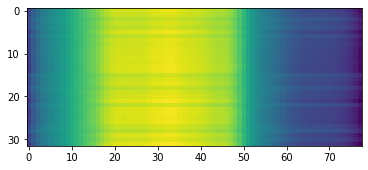

Calculated 200 Batches
Loss 200: 3.840142822265625
08-24 21:57:04


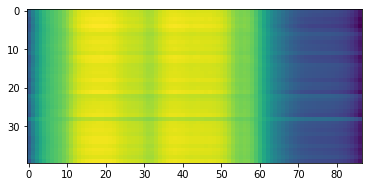

Calculated 300 Batches
Loss 300: 3.8615935643514
08-24 21:57:35


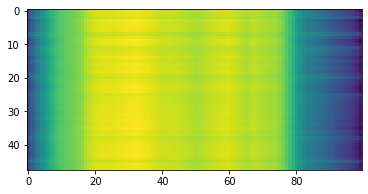

Calculated 400 Batches
Loss 400: 3.78188740123402
08-24 21:58:15


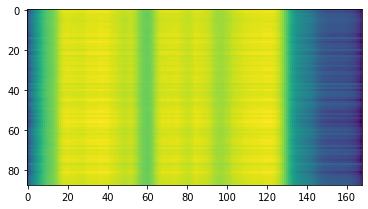

Mean Loss: 3.8250990939994063
----------------------------------------------------
08-24 21:58:17
Calculated 100 Batches
Loss 100: 3.78434681892395
08-24 21:58:35


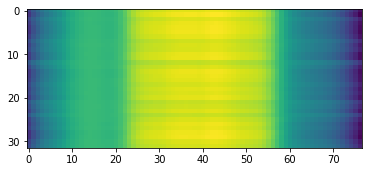

Calculated 200 Batches
Loss 200: 3.822555923461914
08-24 21:59:01


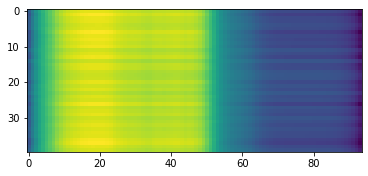

Calculated 300 Batches
Loss 300: 3.838900883992513
08-24 21:59:32


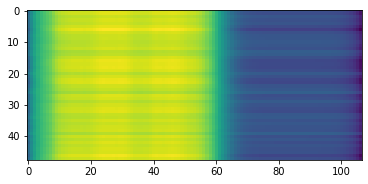

Calculated 400 Batches
Loss 400: 3.7866093028675425
08-24 22:00:12


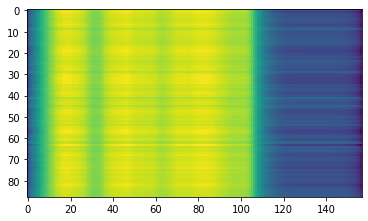

Mean Loss: 3.825090080766554
----------------------------------------------------
08-24 22:00:14
Calculated 100 Batches
Loss 100: 3.8447489738464355
08-24 22:00:32


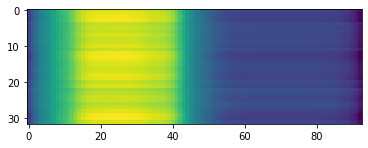

Calculated 200 Batches
Loss 200: 3.8347618103027346
08-24 22:00:57


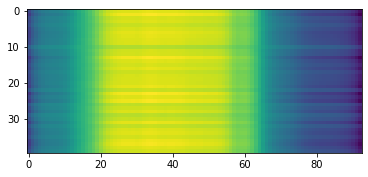

Calculated 300 Batches
Loss 300: 3.8678000768025718
08-24 22:01:28


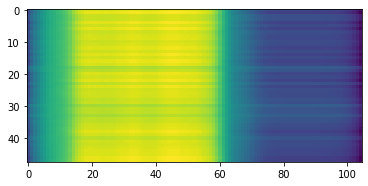

Calculated 400 Batches
Loss 400: 3.788218064741655
08-24 22:02:07


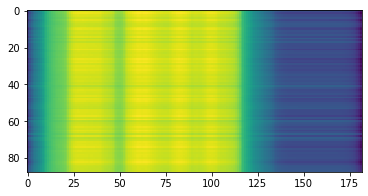

Mean Loss: 3.8255067692603073
----------------------------------------------------
08-24 22:02:09
Calculated 100 Batches
Loss 100: 3.8060550689697266
08-24 22:02:27


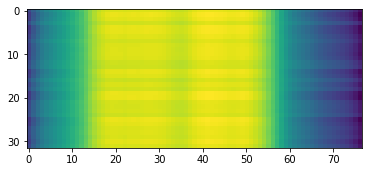

Calculated 200 Batches
Loss 200: 3.8207370758056642
08-24 22:02:53


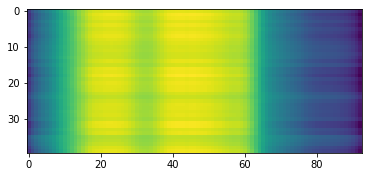

Calculated 300 Batches
Loss 300: 3.871227582295736
08-24 22:03:24


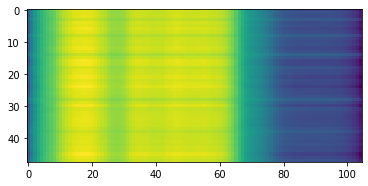

Calculated 400 Batches
Loss 400: 3.801003196022727
08-24 22:04:04


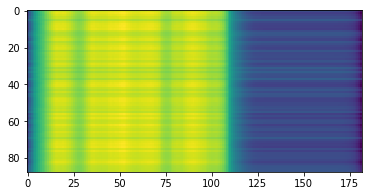

Mean Loss: 3.824786482439264
----------------------------------------------------
08-24 22:04:05
Calculated 100 Batches
Loss 100: 3.7818851470947266
08-24 22:04:23


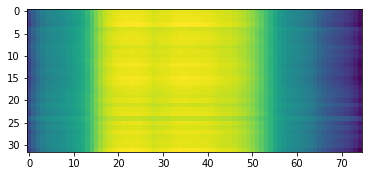

Calculated 200 Batches
Loss 200: 3.7912876129150392
08-24 22:04:49


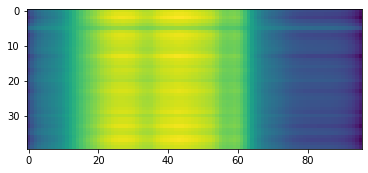

Calculated 300 Batches
Loss 300: 3.850055376688639
08-24 22:05:19


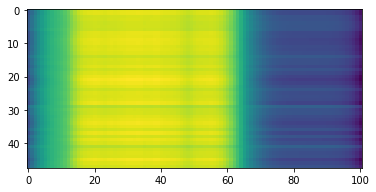

Calculated 400 Batches
Loss 400: 3.792693398215554
08-24 22:05:59


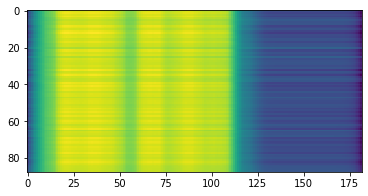

Mean Loss: 3.8253234115765737
----------------------------------------------------
08-24 22:06:01
Calculated 100 Batches
Loss 100: 3.8446719646453857
08-24 22:06:20


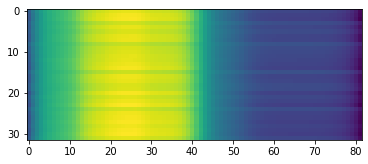

Calculated 200 Batches
Loss 200: 3.826694107055664
08-24 22:06:46


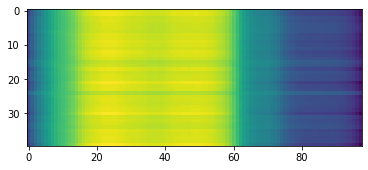

Calculated 300 Batches
Loss 300: 3.8496274948120117
08-24 22:07:18


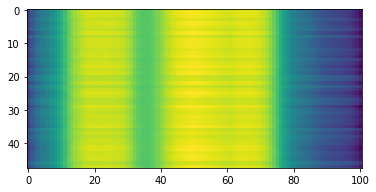

Calculated 400 Batches
Loss 400: 3.7877641157670454
08-24 22:07:57


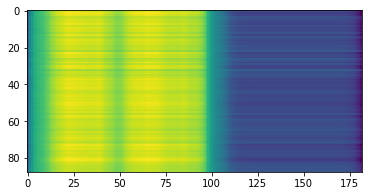

Mean Loss: 3.824732217970712
----------------------------------------------------
08-24 22:07:59
Calculated 100 Batches
Loss 100: 3.8494112491607666
08-24 22:08:17


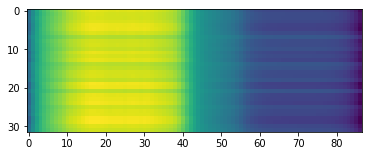

Calculated 200 Batches
Loss 200: 3.856425476074219
08-24 22:08:43


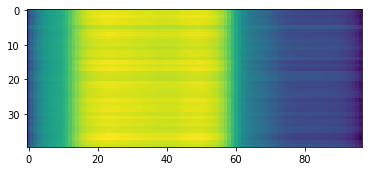

Calculated 300 Batches
Loss 300: 3.8934348424275718
08-24 22:09:14


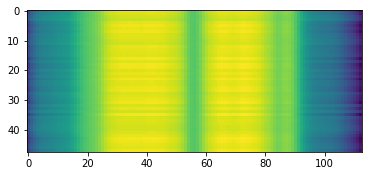

Calculated 400 Batches
Loss 400: 3.7891543995250356
08-24 22:09:54


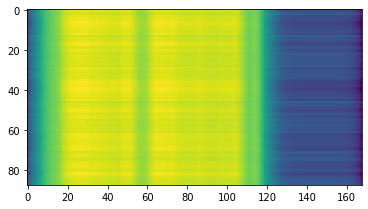

Mean Loss: 3.824326542311468
----------------------------------------------------
08-24 22:09:55
Calculated 100 Batches
Loss 100: 3.7969064712524414
08-24 22:10:13


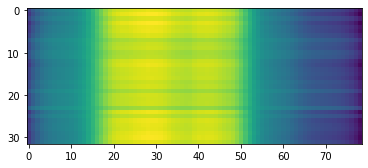

Calculated 200 Batches
Loss 200: 3.8536087036132813
08-24 22:10:39


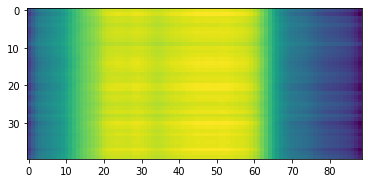

Calculated 300 Batches
Loss 300: 3.8750645319620767
08-24 22:11:10


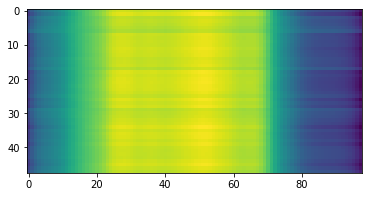

Calculated 400 Batches
Loss 400: 3.78397612138228
08-24 22:11:50


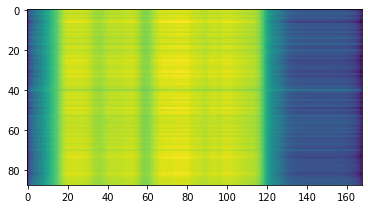

Mean Loss: 3.823980911387216
----------------------------------------------------
08-24 22:11:51
Calculated 100 Batches
Loss 100: 3.788203239440918
08-24 22:12:10


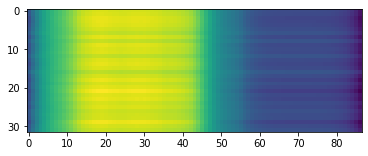

Calculated 200 Batches
Loss 200: 3.83280029296875
08-24 22:12:36


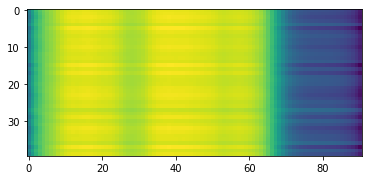

Calculated 300 Batches
Loss 300: 3.89936892191569
08-24 22:13:07


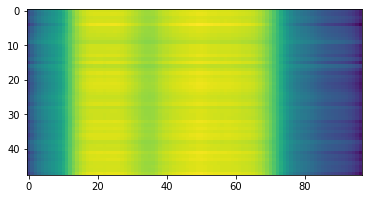

Calculated 400 Batches
Loss 400: 3.7864390286532315
08-24 22:13:47


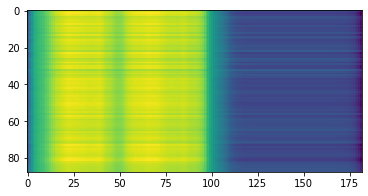

Mean Loss: 3.8245473543615374
----------------------------------------------------
08-24 22:13:48
Calculated 100 Batches
Loss 100: 3.829254150390625
08-24 22:14:07


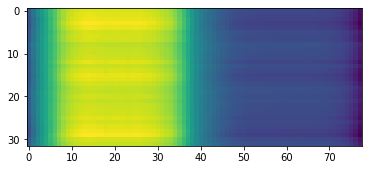

Calculated 200 Batches
Loss 200: 3.864501190185547
08-24 22:14:33


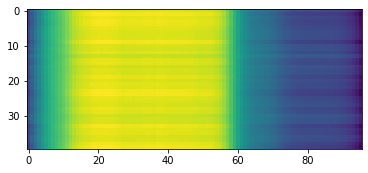

Calculated 300 Batches
Loss 300: 3.8846877415974936
08-24 22:15:04


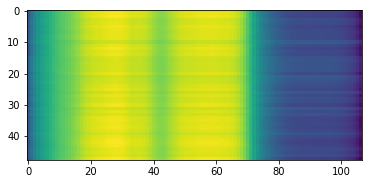

Calculated 400 Batches
Loss 400: 3.790305397727273
08-24 22:15:44


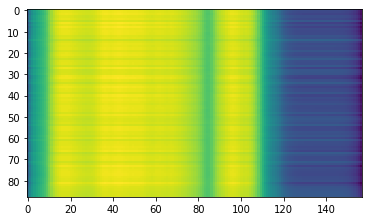

Mean Loss: 3.8227935376383653
----------------------------------------------------
08-24 22:15:46
Calculated 100 Batches
Loss 100: 3.82201886177063
08-24 22:16:04


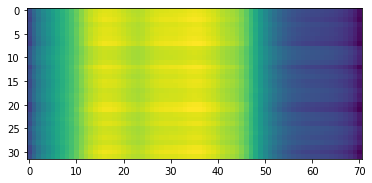

Calculated 200 Batches
Loss 200: 3.8222084045410156
08-24 22:16:30


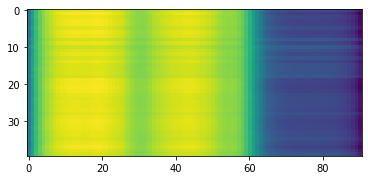

Calculated 300 Batches
Loss 300: 3.8817831675211587
08-24 22:17:01


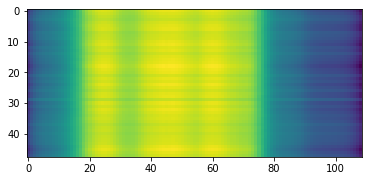

Calculated 400 Batches
Loss 400: 3.784056230024858
08-24 22:17:41


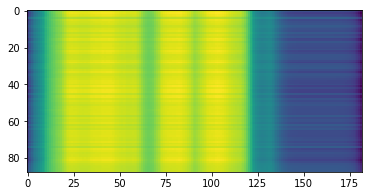

Mean Loss: 3.8218807339313634
----------------------------------------------------
08-24 22:17:42
Calculated 100 Batches
Loss 100: 3.8295693397521973
08-24 22:18:01


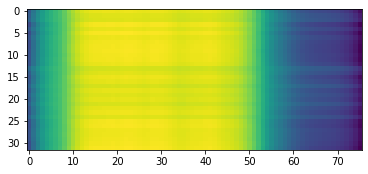

Calculated 200 Batches
Loss 200: 3.8595653533935548
08-24 22:18:26


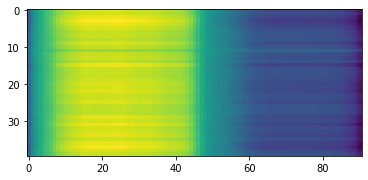

Calculated 300 Batches
Loss 300: 3.8557186126708984
08-24 22:18:57


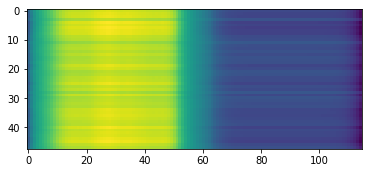

Calculated 400 Batches
Loss 400: 3.7896846424449575
08-24 22:19:37


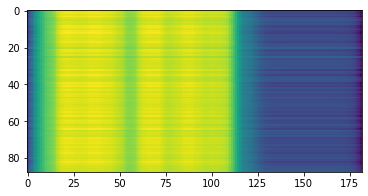

Mean Loss: 3.821399121553641
----------------------------------------------------
08-24 22:19:38
Calculated 100 Batches
Loss 100: 3.819262742996216
08-24 22:19:57


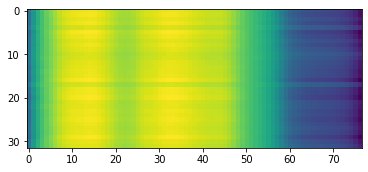

Calculated 200 Batches
Loss 200: 3.8558677673339843
08-24 22:20:23


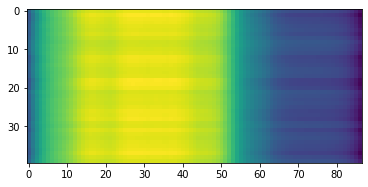

Calculated 300 Batches
Loss 300: 3.862173080444336
08-24 22:20:54


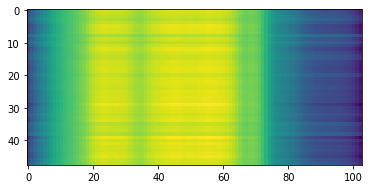

Calculated 400 Batches
Loss 400: 3.786840959028764
08-24 22:21:34


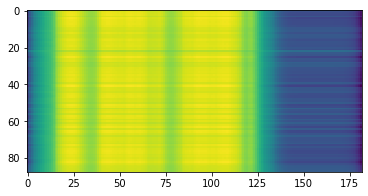

Mean Loss: 3.81837248023878
----------------------------------------------------
08-24 22:21:35
Calculated 100 Batches
Loss 100: 3.8647689819335938
08-24 22:21:54


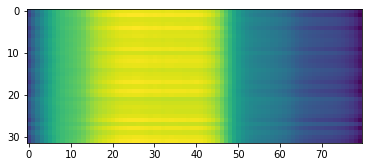

Calculated 200 Batches
Loss 200: 3.822250747680664
08-24 22:22:20


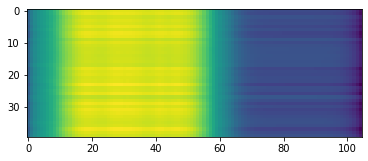

Calculated 300 Batches
Loss 300: 3.846728960673014
08-24 22:22:51


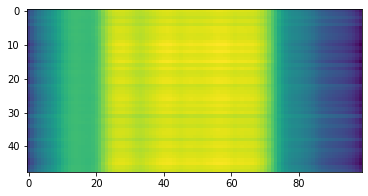

Calculated 400 Batches
Loss 400: 3.7898514487526636
08-24 22:23:30


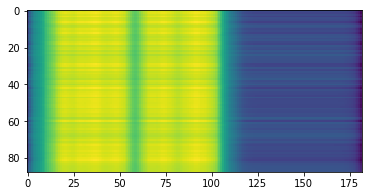

Mean Loss: 3.8182222481439396
----------------------------------------------------
08-24 22:23:32
Calculated 100 Batches
Loss 100: 3.7576732635498047
08-24 22:23:49


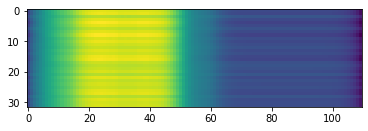

Calculated 200 Batches
Loss 200: 3.865452194213867
08-24 22:24:15


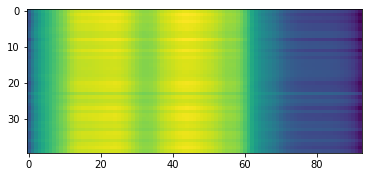

Calculated 300 Batches
Loss 300: 3.8691466649373374
08-24 22:24:46


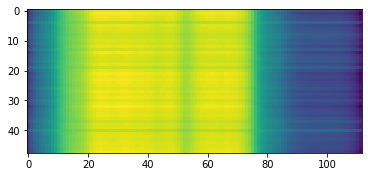

Calculated 400 Batches
Loss 400: 3.797434373335405
08-24 22:25:25


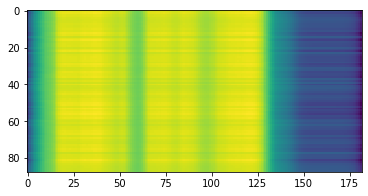

Mean Loss: 3.818154130745095
----------------------------------------------------
08-24 22:25:27
Calculated 100 Batches
Loss 100: 3.8386707305908203
08-24 22:25:45


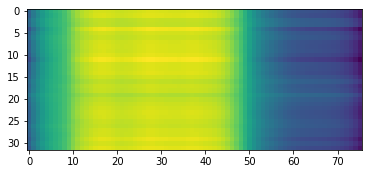

Calculated 200 Batches
Loss 200: 3.794289779663086
08-24 22:26:11


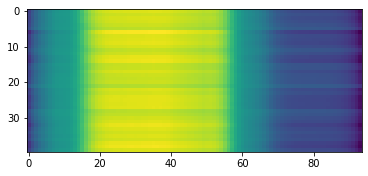

Calculated 300 Batches
Loss 300: 3.8792797724405923
08-24 22:26:42


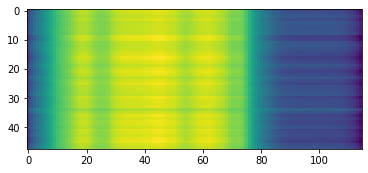

Calculated 400 Batches
Loss 400: 3.7859680869362573
08-24 22:27:23


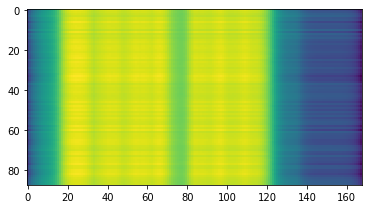

Mean Loss: 3.8176252200308
----------------------------------------------------
08-24 22:27:24
Calculated 100 Batches
Loss 100: 3.8399789333343506
08-24 22:27:43


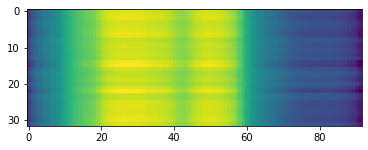

Calculated 200 Batches
Loss 200: 3.8125850677490236
08-24 22:28:08


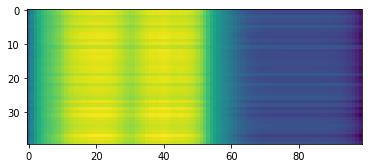

Calculated 300 Batches
Loss 300: 3.8423379262288413
08-24 22:28:39


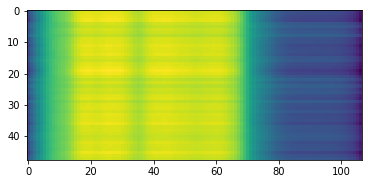

Calculated 400 Batches
Loss 400: 3.7921295166015625
08-24 22:29:19


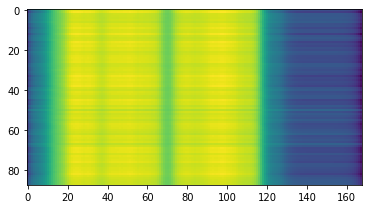

Mean Loss: 3.816509284195368
----------------------------------------------------
08-24 22:29:20
Calculated 100 Batches
Loss 100: 3.787280797958374
08-24 22:29:39


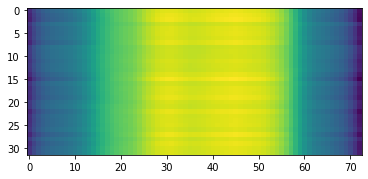

Calculated 200 Batches
Loss 200: 3.8216270446777343
08-24 22:30:05


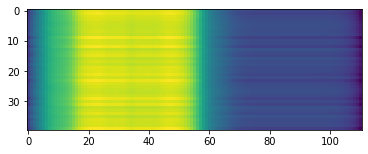

Calculated 300 Batches
Loss 300: 3.8699773152669272
08-24 22:30:43


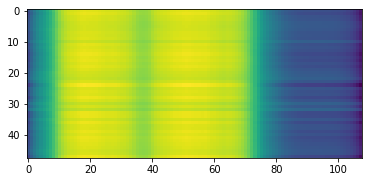

Calculated 400 Batches
Loss 400: 3.77982573075728
08-24 22:31:23


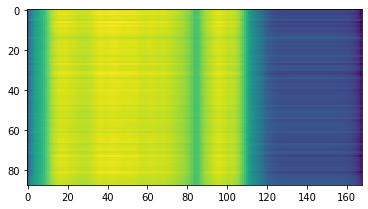

Mean Loss: 3.8161368662299684
----------------------------------------------------
08-24 22:31:25
Calculated 100 Batches
Loss 100: 3.7933661937713623
08-24 22:31:46


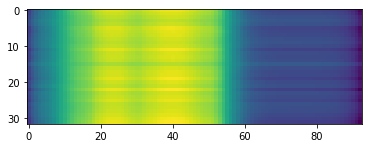

Calculated 200 Batches
Loss 200: 3.839163589477539
08-24 22:32:19


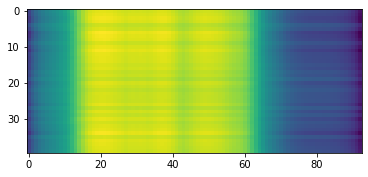

Calculated 300 Batches
Loss 300: 3.8707265853881836
08-24 22:32:50


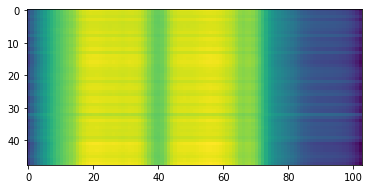

Calculated 400 Batches
Loss 400: 3.801810871471058
08-24 22:33:38


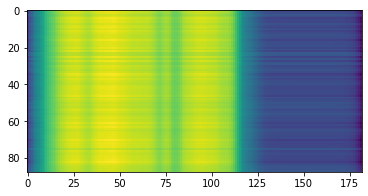

Mean Loss: 3.816623907261173
----------------------------------------------------
08-24 22:33:40
Calculated 100 Batches
Loss 100: 3.7866384983062744
08-24 22:34:05


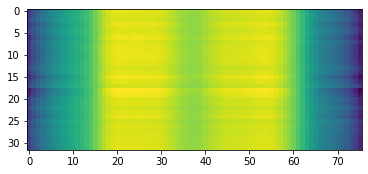

Calculated 200 Batches
Loss 200: 3.865114212036133
08-24 22:34:37


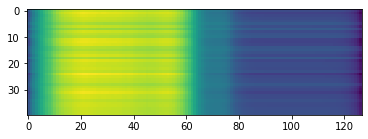

Calculated 300 Batches
Loss 300: 3.8773492177327475
08-24 22:35:09


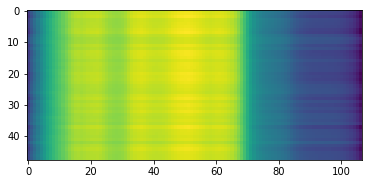

Calculated 400 Batches
Loss 400: 3.784521623091264
08-24 22:35:50


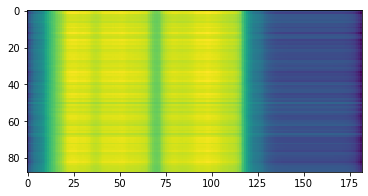

Mean Loss: 3.816507331590575
----------------------------------------------------
08-24 22:35:52
Calculated 100 Batches
Loss 100: 3.859417200088501
08-24 22:36:17


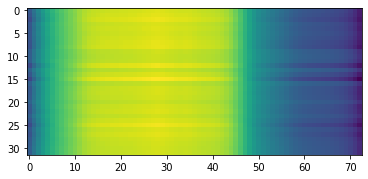

Calculated 200 Batches
Loss 200: 3.824741744995117
08-24 22:36:49


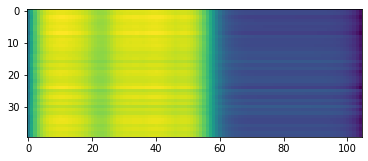

Calculated 300 Batches
Loss 300: 3.8415969212849936
08-24 22:37:30


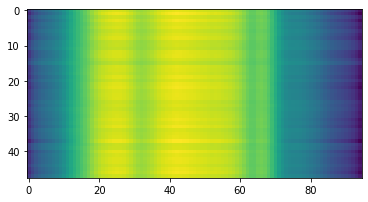

Calculated 400 Batches
Loss 400: 3.783631758256392
08-24 22:38:19


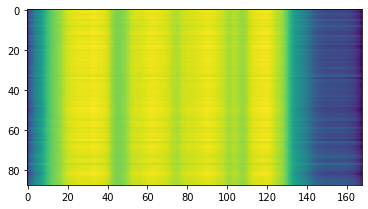

Mean Loss: 3.815981886875305
----------------------------------------------------
08-24 22:38:21
Calculated 100 Batches
Loss 100: 3.7444498538970947
08-24 22:38:46


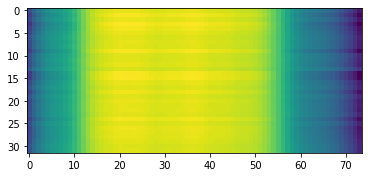

Calculated 200 Batches
Loss 200: 3.7977794647216796
08-24 22:39:19


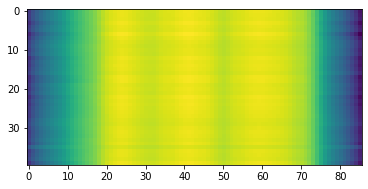

In [ ]:
EPOCH = 30

for epoch in range(EPOCH):
    net.load('check_point_test')
    preloader.initialize_batch()
    counter = 0
    loss_list = list()
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    while preloader.end_flag == False:
        tensor_input, ground_truth, loss_mask = preloader.get_batch()
        pred_tensor, attention_matrix, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device))
        
        counter += 1
        loss_list.append(loss)
        
        if (counter % 100 == 0):
            print('Calculated {} Batches'.format(counter))
            print('Loss {}: {}'.format(counter, loss))
            print(datetime.now().strftime('%m-%d %H:%M:%S'))

            plt.figure()
            plt.imshow(attention_matrix[0].detach().cpu().numpy())
#             plt.colorbar()
            plt.show()
#             _, index = pred_tensor.max(-1)
#             sentence = tokenizer.num2word(index.view(-1))
#             print(''.join(sentence))
#             print(ground_truth[0, :])
            
    net.save('check_point_test')
    print("Mean Loss: {}".format(np.mean(np.asarray(loss_list))))
    print("----------------------------------------------------")

In [ ]:
EPOCH = 1

for epoch in range(EPOCH):
    
    net.load('check_point_test')
    
    for i in tqdm(range(len(metadata))):
        tensor_input = preloader.get(i)
        ground_truth = ground_truth_list[i]
        
        pred_tensor, attention_matrix, loss = net.train(tensor_input.to(device), ground_truth.to(device))
        
        if (i % 100 == 0):
            print(datetime.datetime.now())
            print('Loss {}: {}'.format(i, loss))
            plt.figure()
            plt.imshow(attention_matrix[0].detach().cpu().numpy())
            plt.colorbar()
            plt.show()
            _, index = pred_tensor.max(-1)
            sentence = tokenizer.num2word(index.view(-1))
            print(''.join(sentence))
            print(metadata[i, 2])
    
    net.save('check_point_test')

In [ ]:
plt.figure()
plt.imshow(attention_matrix[0].detach().cpu().numpy())
plt.colorbar()
plt.show()

In [ ]:
print(attention_matrix[0, 0, :].shape)
print(sum(attention_matrix[0, 0, :]))

In [ ]:
net.save('check_point_test')

In [ ]:
net.load('check_point_test')